# Man vs woman vs children - natural

## Loading the packages

In [1]:
import numpy as np
from matplotlib import pyplot as pl
import os
import scipy.io.wavfile as wav

# For model selection
import sys
from ipywidgets import interact, widgets

%matplotlib inline

PATH = 'vowels/'

In [2]:
!pip install python_speech_features
from python_speech_features import mfcc

Defaulting to user installation because normal site-packages is not writeable


## Create the dataset

In [40]:
def create_dataset():
    
    input_data = []
    output_data = []
    
    counter_man = 0
    counter_woman = 0
    counter_children = 0
    
    # iterate over files in vowels/
    for filename in os.listdir(PATH):
        if filename.startswith('nam'):#man
            counter_man = counter_man + 1
            output_data.append([1, -1, -1])
        elif filename.startswith('naf'): #woman
            counter_woman = counter_woman + 1
            output_data.append([-1, 1, -1])
        elif filename.startswith('nk'): #children
            counter_children = counter_children + 1
            output_data.append([-1, -1, 1])
        else:
            continue
        
        # Generate wav file
        sample_rate, X = wav.read(os.path.join(PATH, filename))
        
        # Calculate MFCC coefficients
        ceps = mfcc(X, samplerate=sample_rate, nfft=1024)
        
        # Calculate the features being used to train the model 
        # On doit en choisir un !
        ceps_avg = np.mean(ceps, axis=0)
        #ceps_std = np.std(ceps, axis=0)
        
        input_data.append(ceps_avg)
        
        
    print("Number of men      : ", counter_man)
    print("Number of woman    : ", counter_woman)
    print("Number of children : ", counter_children)
    
    input_data = np.vstack(input_data)
    output_data = np.vstack(output_data)
    
    dataset = np.concatenate((input_data, output_data), axis=1)

    return dataset
    
        
        
dataset = create_dataset()

Number of men      :  36
Number of woman    :  36
Number of children :  108


## Model selection

In [4]:
# MLP
import mlp_backprop_momentum as mlp

In [5]:
import k_fold_cross_validation as cv

### Exploring the number of epochs

In [6]:
N_INITS = 10
EPOCHS = 200
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [7]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,3], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:14]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


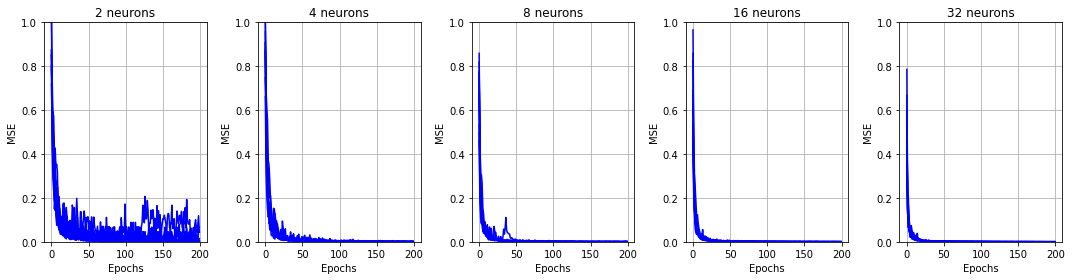

In [8]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

### Exploring the number of hidden neurons

In [9]:
EPOCHS = 100
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

In [10]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...


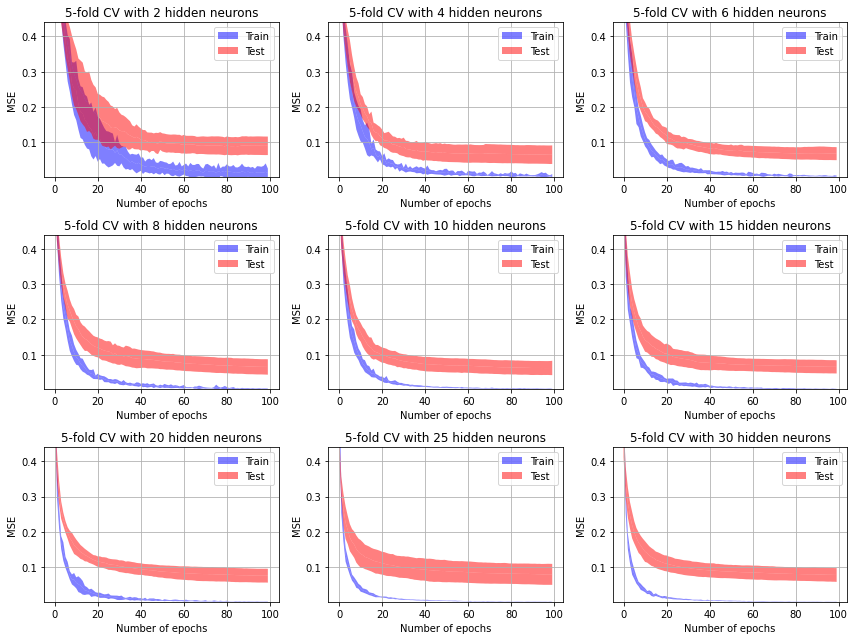

In [11]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

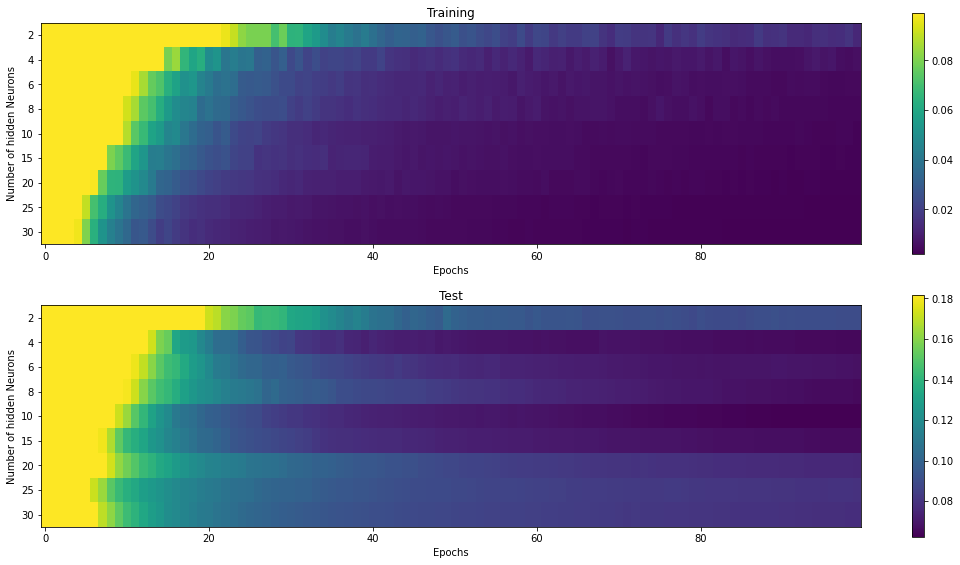

In [12]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

## The final model

In [19]:
nn = mlp.MLP([13,10,3], 'tanh')

In [35]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=80,
                                                          threshold=0.0)

In [36]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.03986242078004454
MSE test:  0.22790373180297568
Confusion matrix:
[[35.  2.  0.]
 [ 0. 25.  9.]
 [ 0.  9. 98.]]


In [37]:
# This function generates a colored confusion matrix.

import matplotlib.cm as cm

def plot_confusion_matrix(confmat, labels_names, ax=None):
    if ax is None:
        ax = pl.subplot(111)
    cmim = ax.matshow(confmat, interpolation='nearest', cmap=cm.jet)

    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.annotate(str(confmat[i, j]), xy=(j, i),
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=8)
    ax.set_xticks(np.arange(confmat.shape[0]))
    ax.set_xticklabels([labels_names[l] for l in range(confmat.shape[0])], rotation='vertical')
    ax.set_yticks(np.arange(confmat.shape[1]))
    _ = ax.set_yticklabels([labels_names[l] for l in range(confmat.shape[1])])
    ax.set_xlabel('predicted label')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('true label')
    pl.colorbar(cmim, shrink=0.7, orientation='horizontal', pad=0.01)

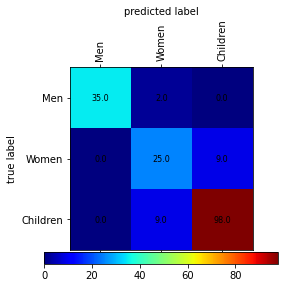

In [38]:
plot_confusion_matrix(conf_mat, labels_names=['Men', 'Women', 'Children'])

In [41]:
# f1 score man
tp = conf_mat[0][0] # correct
fp = conf_mat[0][1] + conf_mat[0][2] # expected chidren or woman but man
fn = conf_mat[1][0] + conf_mat[2][0] # expected man but children or woman
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score_man = 2 * precision * recall / (precision + recall)
print("score man : ", f1_score_man)

# f1 score woman
tp = conf_mat[1][1] # correct 
fp = conf_mat[1][0] + conf_mat[1][2] # expected man or children but got woman
fn = conf_mat[0][1] + conf_mat[2][1] # expected woman but go children or man
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score_woman = 2 * precision * recall / (precision + recall)
print("score woman ", f1_score_woman)

tp = conf_mat[2][2]
fp = conf_mat[2][0] + conf_mat[2][1] # expected woman or man but got child
fn = conf_mat[0][2] + conf_mat[1][2] # expected child but got woman or man
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score_children = 2 * precision * recall / (precision + recall)
print("score children : ", f1_score_man)

f1_score_final = (f1_score_man + f1_score_woman + f1_score_children) / 3
print("score total : ", f1_score_final)






score man :  0.9722222222222222
score woman  0.7142857142857144
score children :  0.9722222222222222
score total :  0.8674652623250755
